In [2]:
import pennylane as qml
import scipy.integrate as integrate
from pennylane import numpy as np
from sympy.combinatorics import GrayCode

import numpy.ma as ma 

from scipy.linalg import norm
import matplotlib.pyplot as plt
    

## Functions definitions

In [3]:
x_min = 0
x_max  = 1
n_qubits = 8

#def normalize(func):
#    def modify(*args, **kwargs):
#        return func(*args, **kwargs)/np.sqrt(np.sum(func(*args, **kwargs)**2))
#    #integrate.quad(func,x_min,x_max)[0]
#    return modify
#def normalize(func):
#    def modify(*args, **kwargs):
#        x = np.linspace(0,1,2**n_qubits)
#        return func(*args, **kwargs)/np.sqrt(np.sum(func(x, **kwargs)**2))
#    return modify

#@normalize
def func_gaussian(x, mu=0.5, sig=1):
    return  1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)

bounds = np.linspace(x_min,x_max,2**(n_qubits+1)+1)

normaliser = np.array([bounds[el] for el in np.arange(1,2**(n_qubits+1)+1,step=2)])

def myfunction(x):
    #normaliser = np.linspace(0,1,2**n_qubits+1)
    return func_gaussian(x)/ norm(func_gaussian(normaliser))

def myfunction2(x):
    return myfunction(x)**2

In [4]:
normaliser

tensor([0.00195312, 0.00585938, 0.00976562, 0.01367188, 0.01757812,
        0.02148438, 0.02539062, 0.02929688, 0.03320312, 0.03710938,
        0.04101562, 0.04492188, 0.04882812, 0.05273438, 0.05664062,
        0.06054688, 0.06445312, 0.06835938, 0.07226562, 0.07617188,
        0.08007812, 0.08398438, 0.08789062, 0.09179688, 0.09570312,
        0.09960938, 0.10351562, 0.10742188, 0.11132812, 0.11523438,
        0.11914062, 0.12304688, 0.12695312, 0.13085938, 0.13476562,
        0.13867188, 0.14257812, 0.14648438, 0.15039062, 0.15429688,
        0.15820312, 0.16210938, 0.16601562, 0.16992188, 0.17382812,
        0.17773438, 0.18164062, 0.18554688, 0.18945312, 0.19335938,
        0.19726562, 0.20117188, 0.20507812, 0.20898438, 0.21289062,
        0.21679688, 0.22070312, 0.22460938, 0.22851562, 0.23242188,
        0.23632812, 0.24023438, 0.24414062, 0.24804688, 0.25195312,
        0.25585938, 0.25976562, 0.26367188, 0.26757812, 0.27148438,
        0.27539062, 0.27929688, 0.28320312, 0.28

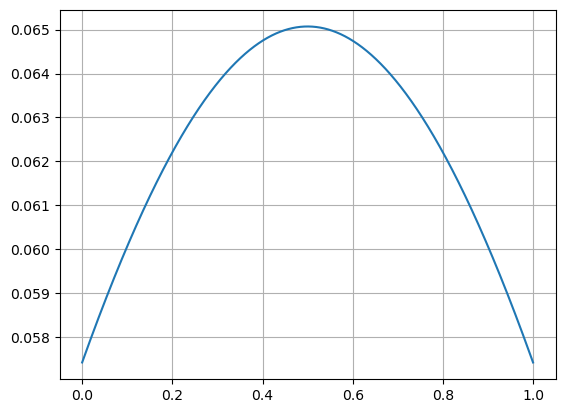

In [5]:

x  = np.linspace(x_min,x_max,10000)
plt.plot(x,myfunction(x))

plt.grid()

## Amplitude Embedding

In [6]:
dev = qml.device("default.qubit", wires=n_qubits)


def _AmplitudeEmbedding(myfunction):
    qml.AmplitudeEmbedding(features=myfunction(normaliser), wires=range(n_qubits), normalize=True)
    return qml.state()

@qml.qnode(dev)
def AmplitudeEmbedding(myfunction):
    return _AmplitudeEmbedding(myfunction)

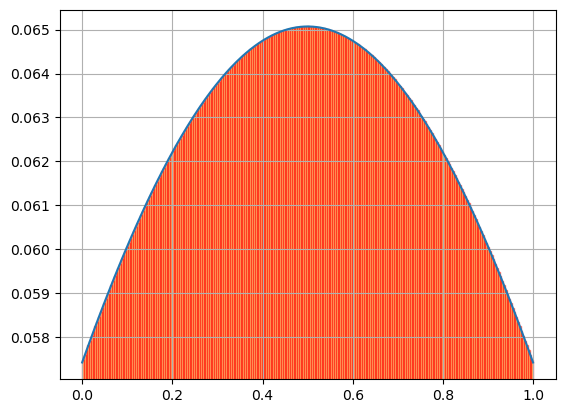

In [7]:
x = np.linspace(x_min,x_max,1000)

fig, ax = plt.subplots()
ax.plot(x,[myfunction(e) for e in x])
ylim = ax.get_ylim()
#normaliser = np.linspace(0,1,2**n_qubits+1)#[:-1]
#print(normaliser)
ax.bar(normaliser,np.real(AmplitudeEmbedding(myfunction)),color='orange',alpha=0.5,edgecolor='red',width = 1/(2**n_qubits))
ax.set_ylim(ylim)
plt.grid()

## Naive Grover Rudolph

### Tools

In [8]:
def Print_naiveResources(circuit, args):
    #print(args)
    #print(*args)
    dict_op = qml.specs(circuit)(*args)["resources"].gate_types
    count = 0
    for op,num in dict_op.items():
        if 'C' in op:
            count+=num
    print("Number of controlled gates (cnot + multicontrolled...) : ", count)

In [9]:
def calculate_inverse_matrix(k):
    M = np.zeros((2**k,2**k))
    a = GrayCode(k)
    l = list(a.generate_gray())
    g_list = []
    for el in l:
        b = np.array(list(el),dtype=int)
        g_list.append(b.dot(2**np.arange(b.size)[::-1]))


    for i in range(2**k):
        for j,g_el in enumerate(g_list):
            M[i,j] = (-1)**int(np.sum(np.array(list(np.binary_repr(np.bitwise_and(i,g_el))),dtype=int)))

    M_inv = 2**(-k)*M.transpose()
    return M_inv

In [10]:
def func_thetas(myfunction2, k, use_inv_matrix=True):

    # k = 1 means one bisection (1 qubits)

    delta_k = (x_max - x_min)/(2**(k-1))
    thetas = []
    for l in range(2**(k-1)):
        # l =0 means first step , cut in half

        
        num = integrate.quad(myfunction2, x_min + l*delta_k, x_min + (l+1/2 )*delta_k)[0]
        denom = integrate.quad(myfunction2, x_min + l*delta_k, x_min + (l+1)*delta_k)[0]
        
        ratio = np.divide(num, denom, out=np.zeros_like(num), where=denom!=0)

        #if(np.isclose(num, 0, rtol=1e-08) and np.isclose(denom, 0, rtol=1e-08)):
        #    continue
        #else:
        #thetas.append(2*np.arccos(np.sqrt(ratio)))
        #thetas.append(2*np.arccos((num/denom)))
    
        if not (abs(num)<1e-7 and abs(denom)<1e-7):
            ratio = np.divide(num, denom, out=np.zeros_like(num), where=denom!=0)
            if ratio>1:
                ratio=1
            thetas.append(2*np.arccos(np.sqrt(ratio)))
        else:
            #if use_inv_matrix:
            thetas.append(0)        

    if(k==1 or not use_inv_matrix):
        return thetas
    #print(np.array(thetas).shape)
    else:
        Minv = calculate_inverse_matrix(k-1)
    ##print(Minv.shape)
        return Minv@np.array(thetas)



for k in range(1,4):
    theta = func_thetas(myfunction2,k)
    print(theta)


[tensor(1.57079633, requires_grad=True)]
[1.57079633 0.06181248]
[1.57079633e+00 1.55761648e-02 5.55111512e-17 3.11598871e-02]


### Circuit block F

In [11]:
def Naive_Grover_Rudolph(k,n,theta):
    """_summary_

    Args:
        k (list): list of qubits numbers to control
        n (int): qubit number to act rotations on
        theta (list): parameters for the 2**k rotations

    Returns:
        _type_: _description_
    """
    if(k==[] or len(theta)==1):
        return qml.RY(theta[0], wires=n)
    
    try:
        assert(2**len(k) == len(theta))
    except:
        print("Error: 2**len(k) and len(theta) are not equal")
        return
        
    for i,theta in enumerate(theta):

        b = np.binary_repr(i,len(k))
        b = [int(el) for el in b]
        qml.ctrl(qml.RY, k , control_values=b)(theta, wires=n)



@qml.qnode(dev)
def Testcircuit_Naive_Grover_Rudolph(k,n,theta):
    Naive_Grover_Rudolph(k,n,theta)
    return qml.state()

Number of controlled gates (cnot + multicontrolled...) :  8


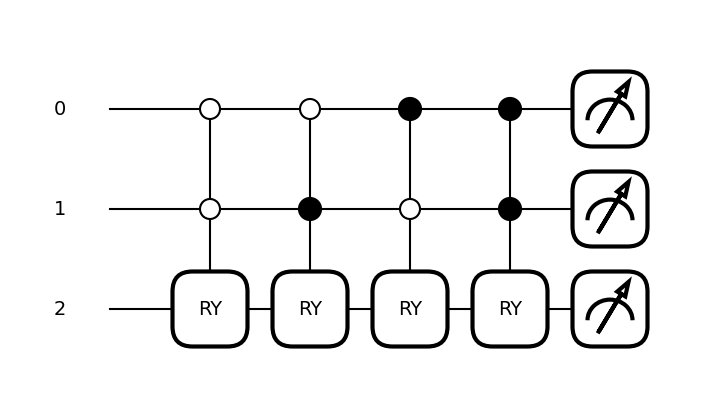

In [12]:
qml.draw_mpl(Testcircuit_Naive_Grover_Rudolph)([0,1],2, np.random.uniform(size=2**2))

Print_naiveResources(Testcircuit_Naive_Grover_Rudolph,([0,1,2],3, np.random.uniform(size=2**3)))

### Full Grover-Rudolph 

In [13]:
def _circuit_Grover_Rudolph(myfunction2,n_qubits=n_qubits,verbose=0):
    
    for k in range(1,n_qubits+1):
        theta = func_thetas(myfunction2,k,use_inv_matrix=False)
        Naive_Grover_Rudolph(list(range(k-1)),k-1,theta,)
    return qml.state()


In [14]:
@qml.qnode(dev)
def circuit_Grover_Rudolph(myfunction2,n_qubits=n_qubits,verbose=0):
    return _circuit_Grover_Rudolph(myfunction2,n_qubits=n_qubits,verbose=0)

(<Figure size 25800x900 with 1 Axes>, <Axes: >)

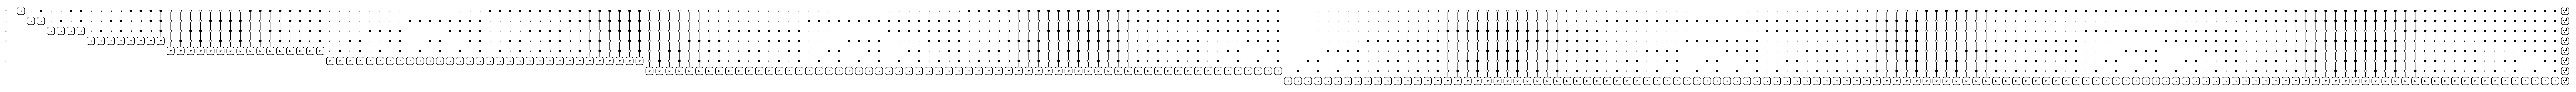

In [15]:
qml.draw_mpl(circuit_Grover_Rudolph)(myfunction2)

In [16]:
qml.math.fidelity_statevector(AmplitudeEmbedding(myfunction),circuit_Grover_Rudolph(myfunction2))

tensor(1., requires_grad=True)

/Users/Brian/workspace/Research/QHack2024/.conda/lib/python3.11/site-packages/matplotlib/transforms.py:766: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


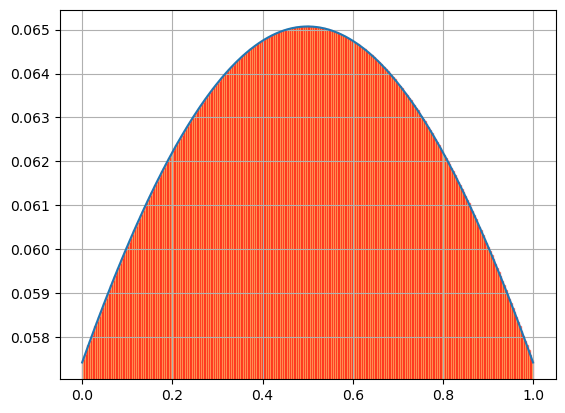

In [17]:
x = np.linspace(x_min,x_max,1000)

fig, ax = plt.subplots()
ax.plot(x,[myfunction(e) for e in x])
ylim = ax.get_ylim()
ax.bar(normaliser,circuit_Grover_Rudolph(myfunction2),color='orange',edgecolor='red',alpha=0.5,width = 1/(2**n_qubits))
ax.set_ylim(ylim)
plt.grid()

## Möttönen circuit

In [18]:
def F_Mottonen(k,n,theta):
    """_summary_

    Args:
        k (list): list of qubits numbers to control
        n (int): qubit number to act rotations on
        theta (list): parameters for the 2**k rotations

    Returns:
        _type_: _description_
    """
    if(k==[] or len(theta)==1):
        return qml.RY(theta[0], wires=n)
    
    if(2**len(k) != len(theta)):
        print("Warning k is not compatible with theta")
        
    
    def generate_gray_code(n):
        a = GrayCode(n)
        l = list(a.generate_gray())+['0'*n]
        
        cnot_positions = []
        for i in range(len(l[:-1])):
            y=int(l[i],2) ^ int(l[i+1],2)
            z =  str('{0:0{1}b}'.format(y,len(l[i])))
            
            cnot_positions.append(z.find('1'))
        return cnot_positions
    
    cnot_positions = [k[el] for el in generate_gray_code(len(k))]
    for theta_i,cnot_i in list(zip(theta,cnot_positions)):
        qml.RY(theta_i ,wires = n)
        qml.CNOT(wires=[cnot_i,n])
   



@qml.qnode(dev)
def Testcircuit_Mottonen(k,n,theta):
    F_Mottonen(k,n,theta)
    return qml.state()

Number of controlled gates (cnot + multicontrolled...) :  4


(<Figure size 1100x400 with 1 Axes>, <Axes: >)

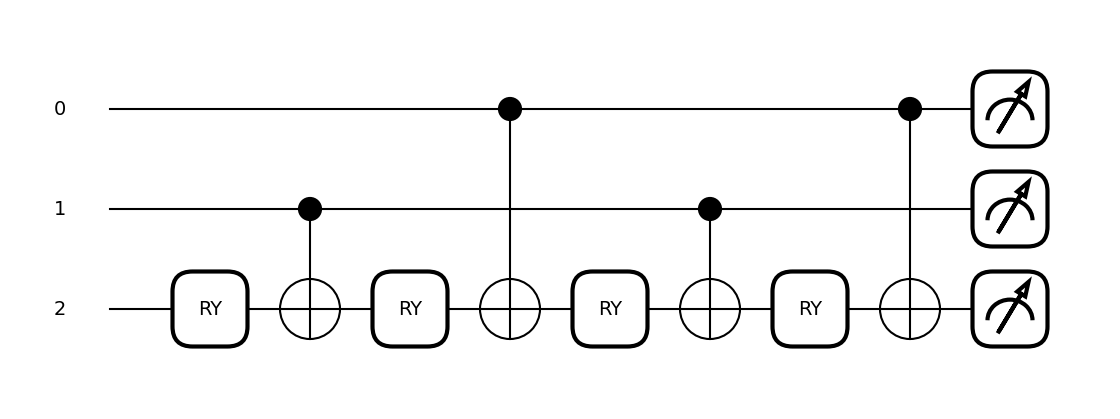

In [19]:
Print_naiveResources(Testcircuit_Mottonen,([0,1],2, np.random.uniform(size=2**2)))
qml.draw_mpl(Testcircuit_Mottonen)([0,1],2, np.random.uniform(size=2**2))

In [20]:

def _circuit_Mottonen(myfunction2,n_qubits=n_qubits):
    for k in range(1,n_qubits+1):
        theta = func_thetas(myfunction2,k,use_inv_matrix=True)
        F_Mottonen(list(range(k-1)),k-1,theta)

    return qml.state()

In [21]:
@qml.qnode(dev)
def circuit_Mottonen(myfunction2,n_qubits=n_qubits):
    return _circuit_Mottonen(myfunction2,n_qubits=n_qubits)

Number of controlled gates (cnot + multicontrolled...) :  254
0.9999999999999907


(<Figure size 50500x900 with 1 Axes>, <Axes: >)

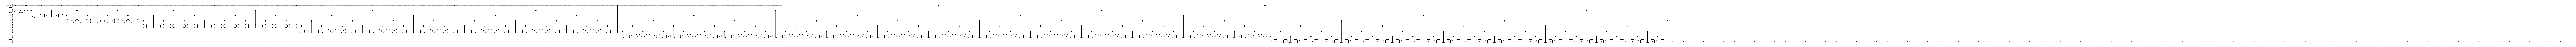

In [22]:
Print_naiveResources(circuit_Mottonen,[myfunction2])
print(qml.math.fidelity_statevector(AmplitudeEmbedding(myfunction),circuit_Mottonen(myfunction2)))

qml.draw_mpl(circuit_Mottonen)(myfunction2)

## First Algorithm 

In [23]:

def _circuit_FirstAlgorithm(myfunction2,eta, k0, verbose=0,n_qubits=n_qubits):
    
    for k in range(1,k0+1):
        theta = func_thetas(myfunction2,k,use_inv_matrix=True)
        F_Mottonen(list(range(k-1)),k-1,theta)
        
    for k in range(k0,n_qubits):
        theta = func_thetas(myfunction2,k+1,use_inv_matrix=False)
        theta_representative = np.mean(theta)

        delta_k = (x_max - x_min)/(2**(k-1))
        eta_k = delta_k / 8 * eta
        if(verbose>=1):
            if (np.all(np.abs(theta-theta_representative)< eta_k)):
                print("representative ", k," is legit")
            else:
                #print(theta)
                print("Warning: representative ", k," is not legit")
            
        qml.RY(theta_representative,wires=k)
    return np.real(qml.state())

In [24]:
@qml.qnode(dev)
def circuit_FirstAlgorithm(myfunction2,eta, k0, verbose=0,n_qubits=n_qubits):
    return _circuit_FirstAlgorithm(myfunction2,eta, k0, verbose=verbose,n_qubits=n_qubits)

Number of controlled gates (cnot + multicontrolled...) :  30
(<Figure size 6000x900 with 1 Axes>, <Axes: >)


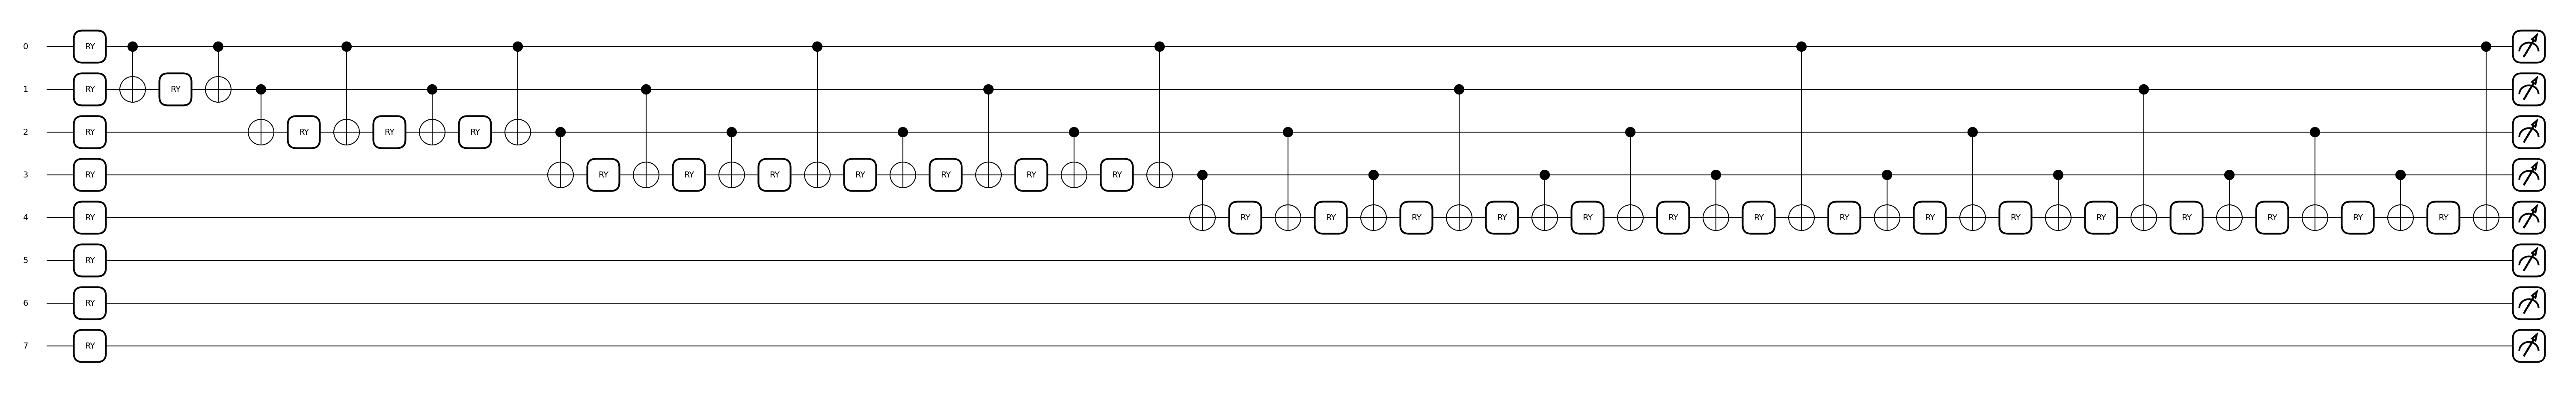

In [25]:
k0 = 5
Print_naiveResources(circuit_FirstAlgorithm,[myfunction2,2,k0])
#print(2**4-1)
print(qml.draw_mpl(circuit_FirstAlgorithm)(myfunction2,2,k0))

In [26]:
eta = 2
k0 = 5

fstate = circuit_FirstAlgorithm(myfunction2,eta,k0,verbose=1)
qml.math.fidelity_statevector(AmplitudeEmbedding(myfunction),fstate)

representative  5  is legit
representative  6  is legit
representative  7  is legit


tensor(0.99999376, requires_grad=True)

/Users/Brian/workspace/Research/QHack2024/.conda/lib/python3.11/site-packages/matplotlib/transforms.py:766: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


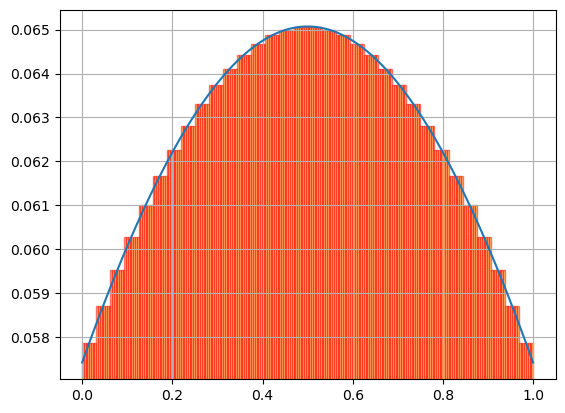

In [27]:
x = np.linspace(x_min,x_max,1000)

fig, ax = plt.subplots()
ax.plot(x,[myfunction(e) for e in x])
ylim = ax.get_ylim()

ax.bar(normaliser,fstate,color='orange',edgecolor='red',alpha=0.5,width = 1/(2**n_qubits))
ax.set_ylim(ylim)
plt.grid()

## $k^{0}$ calculation for epsilon (related to error demanded) / eta (related function second derivative bounded)

In [28]:
def k0(epsilon,eta,n =1000):
    val = -1/2*np.log2(4**(-n) - 96/eta**2*np.log(1-epsilon))
    return np.maximum(np.ceil(val),2)


/Users/Brian/workspace/Research/QHack2024/.conda/lib/python3.11/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log2
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


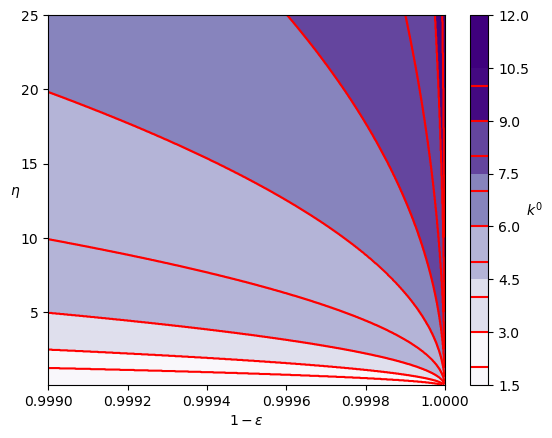

In [29]:
import matplotlib as mpl

fig1, ax2 = plt.subplots()


eta = np.linspace(0.1,25,1000)
epsilon = np.linspace(0.,0.001,1000)
Epsilon, Eta = np.meshgrid(epsilon, eta)

CS = ax2.contourf(1-Epsilon, Eta, k0(Epsilon,Eta,n=1000), cmap=mpl.colormaps["Purples"], vmin = 2, vmax = 10)

CS2 = ax2.contour(CS, colors='r',levels=list(range(2,11)), vmin = 2, vmax=10)

#ax2.set_title('$k^0$')
ax2.set_xlabel('$1-\epsilon$')
ax2.set_ylabel('$\eta$',rotation=0)

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('$k^0$',rotation=0)
# Add the contour line levels to the colorbar
cbar.add_lines(CS2)

## Black Scholes

In [30]:
n_qubits = 5

K = 45
c = 3
s = K*c
x_min = -np.log(K*s)
x_max = np.log(K*s)
#x_min = -10
#x_max = 10


bounds = np.linspace(x_min,x_max,2**(n_qubits+1)+1)
normaliser = np.array([bounds[el] for el in np.arange(1,2**(n_qubits+1)+1,step=2)])



def wildBS(x):
    if(x >= -np.log(K*s) and x < 0):
        return K - np.exp(-x)/s
    elif(x <= np.log(K*s) and x > 0):
        return K - np.exp(x)/s
    else:
        return 0

vildBS = np.vectorize(wildBS)

def BS(x):
    return vildBS(x)/ norm(vildBS(normaliser))

def BS2(x):
    return BS(x)**2



#def func_gaussian(x, mu=0.5, sig=1):
#    return  1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)

#def BS(x):
#    #normaliser = np.linspace(0,1,2**n_qubits+1)
#    return func_gaussian(x)/ norm(func_gaussian(normaliser))

#def BS2(x):
#    return BS(x)**2

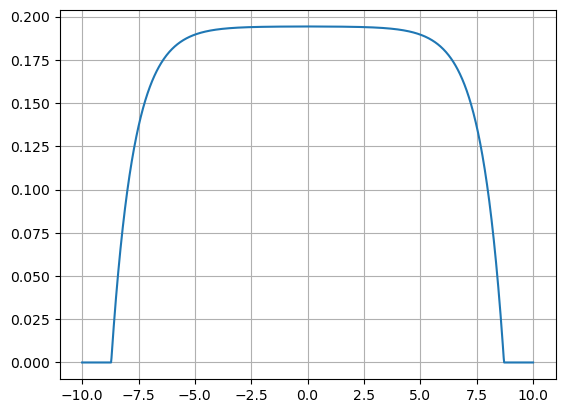

In [31]:
x = np.linspace(-10,10,1000)
plt.plot(x,[BS(e) for e in x])
plt.grid()

### Circuit redefinition

In [32]:
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def AmplitudeEmbedding(myfunction):
    return _AmplitudeEmbedding(myfunction)

@qml.qnode(dev)
def circuit_Grover_Rudolph(myfunction2,n_qubits=n_qubits,verbose=0):
    return _circuit_Grover_Rudolph(myfunction2,n_qubits=n_qubits,verbose=0)

@qml.qnode(dev)
def circuit_Mottonen(myfunction2,n_qubits=n_qubits):
    return _circuit_Mottonen(myfunction2,n_qubits=n_qubits)

@qml.qnode(dev)
def circuit_FirstAlgorithm(myfunction2,eta, k0, verbose=0,n_qubits=n_qubits):
    return _circuit_FirstAlgorithm(myfunction2,eta, k0, verbose=verbose,n_qubits=n_qubits)

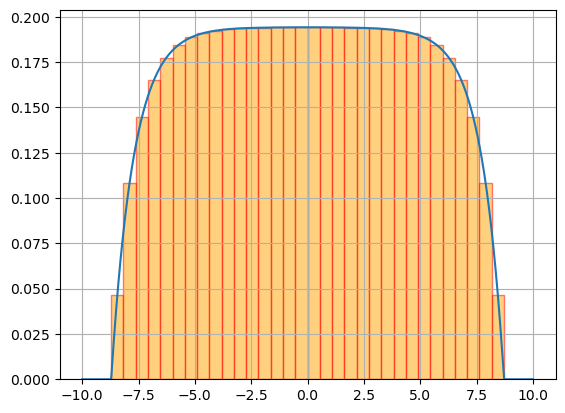

In [33]:
x = np.linspace(-10,10,1000)
plt.plot(x,[BS(e) for e in x])

plt.bar(normaliser,AmplitudeEmbedding(BS),color='orange',edgecolor='red', alpha=0.5, width = (x_max-x_min)/(2**n_qubits))
plt.grid()

In [34]:
print("Grover-Rudolph:  ", qml.math.fidelity_statevector(AmplitudeEmbedding(BS),circuit_Grover_Rudolph(BS2)))
print("Möttönen:        ", qml.math.fidelity_statevector(AmplitudeEmbedding(BS),circuit_Mottonen(BS2)))
print("First algo:      ", qml.math.fidelity_statevector(AmplitudeEmbedding(BS),circuit_FirstAlgorithm(BS2,2,2)))

Grover-Rudolph:   0.9999675044117566
Möttönen:         0.9999675044117564
First algo:       0.9637541118138196


In [36]:
Print_naiveResources(circuit_FirstAlgorithm,(BS2,2,2))

Number of controlled gates (cnot + multicontrolled...) :  2


In [ ]:
print(normaliser)
circuit_Grover_Rudolph(BS2)

[-8.43968923 -7.89519315 -7.35069707 -6.80620099 -6.26170491 -5.71720883
 -5.17271275 -4.62821667 -4.08372059 -3.53922452 -2.99472844 -2.45023236
 -1.90573628 -1.3612402  -0.81674412 -0.27224804  0.27224804  0.81674412
  1.3612402   1.90573628  2.45023236  2.99472844  3.53922452  4.08372059
  4.62821667  5.17271275  5.71720883  6.26170491  6.80620099  7.35069707
  7.89519315  8.43968923]


tensor([0.05029384+0.j, 0.10823539+0.j, 0.14408341+0.j, 0.1651005 +0.j,
        0.17733843+0.j, 0.18444995+0.j, 0.18857909+0.j, 0.19097564+0.j,
        0.19236631+0.j, 0.1931732 +0.j, 0.19364135+0.j, 0.19391295+0.j,
        0.19407051+0.j, 0.19416193+0.j, 0.19421496+0.j, 0.19424572+0.j,
        0.19424572+0.j, 0.19421496+0.j, 0.19416193+0.j, 0.19407051+0.j,
        0.19391295+0.j, 0.19364135+0.j, 0.1931732 +0.j, 0.19236631+0.j,
        0.19097564+0.j, 0.18857909+0.j, 0.18444995+0.j, 0.17733843+0.j,
        0.1651005 +0.j, 0.14408341+0.j, 0.10823539+0.j, 0.05029384+0.j], requires_grad=True)

In [ ]:
Print_naiveResources(circuit_Mottonen,[BS2])
Print_naiveResources(circuit_FirstAlgorithm, [BS2,2,2])

Number of controlled gates (cnot + multicontrolled...) :  30
Number of controlled gates (cnot + multicontrolled...) :  2


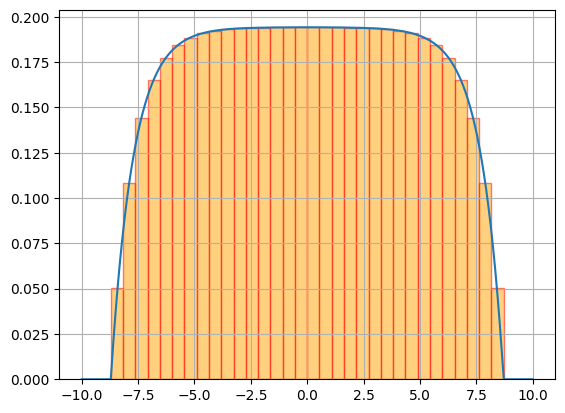

In [ ]:
x = np.linspace(-10,10,1000)
plt.plot(x,[BS(e) for e in x])

plt.bar(normaliser,circuit_Grover_Rudolph(BS2),color='orange',edgecolor='red', alpha=0.5, width = (x_max-x_min)/(2**n_qubits))
plt.grid()

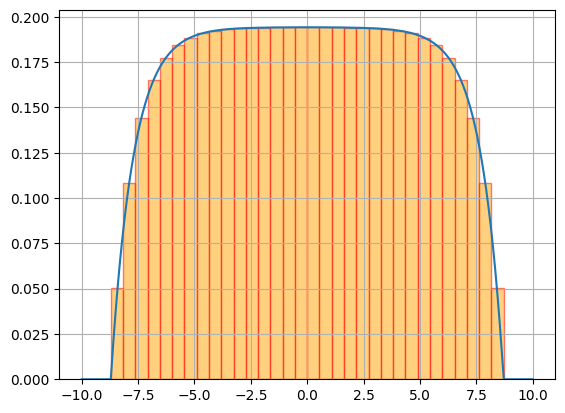

In [ ]:
x = np.linspace(-10,10,1000)
plt.plot(x,[BS(e) for e in x])

plt.bar(normaliser,circuit_Mottonen(BS2),color='orange',edgecolor='red', alpha=0.5, width = (x_max-x_min)/(2**n_qubits))
plt.grid()

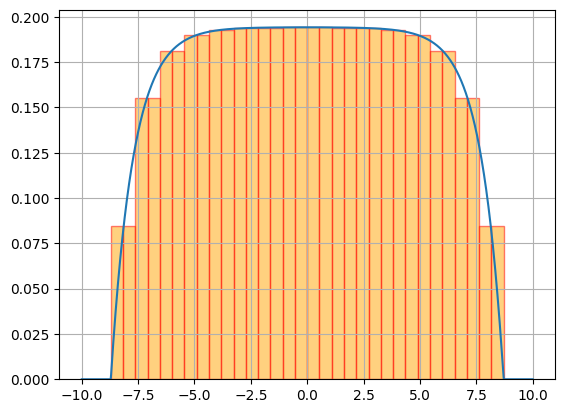

In [ ]:
x = np.linspace(-10,10,1000)
plt.plot(x,[BS(e) for e in x])

plt.bar(normaliser,circuit_FirstAlgorithm(BS2,2,4,verbose=1),color='orange',edgecolor='red', alpha=0.5, width = (x_max-x_min)/(2**n_qubits))
plt.grid()

In [ ]:
circuit_FirstAlgorithm(BS2,2,4,verbose=1)

tensor([0.08439304+0.j, 0.08439304+0.j, 0.15494871+0.j, 0.15494871+0.j,
        0.18092914+0.j, 0.18092914+0.j, 0.18978115+0.j, 0.18978115+0.j,
        0.19277018+0.j, 0.19277018+0.j, 0.19377719+0.j, 0.19377719+0.j,
        0.19411623+0.j, 0.19411623+0.j, 0.19423034+0.j, 0.19423034+0.j,
        0.19423034+0.j, 0.19423034+0.j, 0.19411623+0.j, 0.19411623+0.j,
        0.19377719+0.j, 0.19377719+0.j, 0.19277018+0.j, 0.19277018+0.j,
        0.18978115+0.j, 0.18978115+0.j, 0.18092914+0.j, 0.18092914+0.j,
        0.15494871+0.j, 0.15494871+0.j, 0.08439304+0.j, 0.08439304+0.j], requires_grad=True)

## Variational ansatz

In [ ]:
# THIS PART IS NOT FINISHED...
lol_hardstopper

In [ ]:
x_min = 0
x_max  = 3*np.pi/2
n_qubits = 5



bounds = np.linspace(x_min,x_max,2**(n_qubits+1)+1)

normaliser = np.array([bounds[el] for el in np.arange(1,2**(n_qubits+1)+1,step=2)])

def myfunction(x):
    return np.sin(x)/ norm(np.sin(normaliser))

def myfunction2(x):
    return myfunction(x)**2

In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def AmplitudeEmbedding():
    #normaliser = np.array([bounds[el] for el in np.arange(1,2**(n_qubits+1)+1,step=2)])
    qml.AmplitudeEmbedding(features=myfunction(normaliser), wires=range(n_qubits), normalize=True)
    return np.real(qml.state())
print(AmplitudeEmbedding())

[ 0.01839114+0.j  0.05477531+0.j  0.08997376+0.j  0.12322455+0.j
  0.1538079 +0.j  0.18106177+0.j  0.2043962 +0.j  0.22330608+0.j
  0.23738205+0.j  0.24631941+0.j  0.2499247 +0.j  0.24811988+0.j
  0.24094402+0.j  0.22855244+0.j  0.21121339+0.j  0.18930221+0.j
  0.16329321+0.j  0.1337494 +0.j  0.10131033+0.j  0.06667819+0.j
  0.03060267+0.j -0.00613531+0.j -0.04274047+0.j -0.07842044+0.j
 -0.11240283+0.j -0.14395205+0.j -0.17238514+0.j -0.19708661+0.j
 -0.21752175+0.j -0.2332482 +0.j -0.24392553+0.j -0.24932261+0.j]


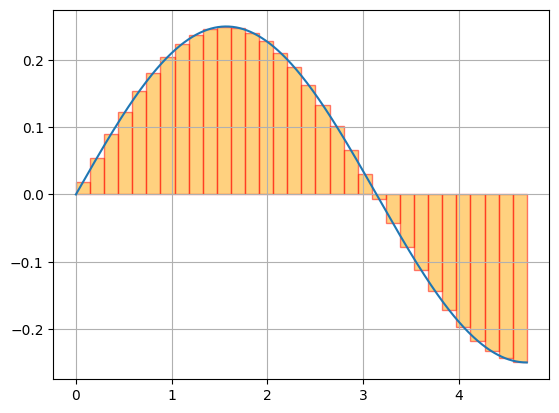

In [ ]:
x = np.linspace(x_min,x_max,1000)

fig, ax = plt.subplots()
ax.plot(x,[myfunction(e) for e in x])
ylim = ax.get_ylim()
ax.bar(normaliser,AmplitudeEmbedding(),color='orange',edgecolor='red',alpha=0.5,width = (x_max-x_min)/(2**n_qubits))
ax.set_ylim(ylim)
plt.grid()

Zeros are situated at positions '00000' '10101'

No other singular points

In [ ]:
import itertools

class Ansatz:

    def __init__(self, myfunction, myfunction2, dict_special: dict, eta=None, k0 = None, p_k = 1, verbose=0, n_qubits=n_qubits):
        """_summary_

        Args:
            myfunction2 (_type_): _description_
            dict_special (_type_): dict of special points  position -> type for each singularity or zero (also called "special" point)
            eta (_type_): _description_
            k0 (_type_, optional): order from which clusterisation is performed
            p_k (_type_):  number of parameters per special point
            verbose (int, optional): _description_. Defaults to 0.
            n_qubits (_type_, optional): _description_. Defaults to n_qubits.

        Returns:
            _type_: _description_
        """

        # General assignations
        self.n_qubits = n_qubits
        self.myfunction = myfunction
        self.myfunction2 = myfunction2
        self.eta = eta
        self.k0 = k0

        # target value for variational algorithm
        self.target_state = self.myfunction(normaliser)
        
        old_dict = dict_special.copy()
        
        for _binary_pos,_type in old_dict.items():
            if(_type==2):
                dict_special[ np.binary_repr(int(_binary_pos,2)+1)] = 0
            dict_special[_binary_pos] = 0
        print(dict_special)
        self.num_special = len(dict_special)
        self.positions_special =  list(dict_special.keys())
        


        # for now p_k is a constant (not a polynomial in k)
        _power2 = 2**np.array(range(self.n_qubits))

        self.p_k = p_k
        if(callable(p_k)):
            p_array = [self.num_special*p_k(k)+1 for k in range(self.n_qubits)]
            # in case p_k(k) = k, first elements gives 1  == _power2[0] . 
            p_array[0] = 100
        elif(type(p_k)==int):
            p_array = [self.num_special*p_k+1 for _ in range(self.n_qubits)]
        else:
            print("Error: p_k must be an int or a function")

        self.k0 = np.argmax((_power2 - p_array) >= 0)
        print(_power2 - p_array)
        print("k0 = ", self.k0)
        #self.theta_size = (self.num_special)*p_k

        _total_num_angles = sum(_power2[:self.k0]) + sum(p_array[self.k0:])
        _total_var_angles = sum(p_array[self.k0:]) - (self.n_qubits-self.k0)
        self.total_var_angles = _total_var_angles
        print("The total number of angles is ", _total_num_angles)
        print("The total number of variational parameters is ", _total_var_angles)
        self.var_angles_per_layer = np.array(p_array) - 1


        # Need GR values for clustering
        # remark: computation is redone each time in variational algorithm. maybe store them once and for all somewhere
        # lol solved
        self.thetas_GR = []
        self.thetas_GR_init = []
        self.list_special_with_pk = []

        for k in range(self.k0, n_qubits):
            theta_GR_local = func_thetas(myfunction2,k+1,use_inv_matrix=False)
            self.thetas_GR.append(theta_GR_local)
            
        # Create new list_special_with_pk taking into account p_k parameters around each singularity. Remove duplicates   
            if(callable(self.p_k)):
                p_k_local = self.p_k(k)
            elif(type(self.p_k)==int):
                p_k_local = self.p_k
            
            local_list_special_with_pk = []
            for el in dict_special:    
                for j in range(p_k_local):
                    displacement = j - p_k_local//2
                    new_element = int(el[:k])+displacement
                    if(new_element < 0 or new_element >= 2**k):
                        continue
                local_list_special_with_pk.append(np.binary_repr(int(el[:k],2)+displacement,width=k))
            self.list_special_with_pk.append(sorted(set(local_list_special_with_pk)))
            
            mask_singular_positions = np.ones(2**k)
            for el in self.list_special_with_pk[k-self.k0]:
                mask_singular_positions[int(el,2)] = 0

            theta_GR_singular = ma.masked_array(theta_GR_local, mask_singular_positions)

            self.thetas_GR_init.append(theta_GR_singular.compressed())
            
    def GR_Mottonen_part(self):
        for k in range(1,self.k0):
            theta = func_thetas(self.myfunction2, k,use_inv_matrix=True)
            
            F_Mottonen(list(range(k-1)),k-1,theta)

    def variational_subcircuit(self,thetas):
        
    # Take good theta slice for variational parameters (singular values) 
        thetas_layers = np.array_split(thetas, np.cumsum(self.var_angles_per_layer[self.k0:]))
        
        #print(thetas_layers)
        #print(self.list_special_with_pk)
        if (np.size(thetas_layers[-1])):
            print(" Error: sanity check 1")
            return None

        self.mask_nonsingular_GR_values = []
        for k in range(self.k0, n_qubits):

        # Need GR values for clustering
            thetas_GR_local = self.thetas_GR[k-self.k0]

            if(len(thetas_layers[k-self.k0]) != len(self.list_special_with_pk[k-self.k0])):
                print(" Error: sanity check 2_",k)
                print(len(thetas_layers[k-self.k0])," != ", len(self.list_special_with_pk[k-self.k0]))
                return None
        
            mask_non_singular_positions = np.zeros(2**k)
            for el in self.list_special_with_pk[k-self.k0]:
                mask_non_singular_positions[int(el,2)] = 1

        # We cluster all non-singular positions
            theta_to_cluster = ma.masked_array(thetas_GR_local, mask_non_singular_positions)
            theta_clustered = np.mean(theta_to_cluster)

        # Perform dedicated rotations for singularities
            for i, controls in enumerate(self.list_special_with_pk[k-self.k0]):
                controls = [int(el) for el in controls]
                qml.ctrl(qml.RY, list(range(k)) , control_values=controls)(thetas_layers[i] - theta_clustered, wires=k)
            
        # Perform clustered rotation
            qml.RY(theta_clustered,wires=k)


    def old_variational_subcircuit(self,thetas):
        """_summary_

        Args:
            thetas (_type_): parameters as a list of list or a 2D numpy array
        """
        #if ((np.array(thetas)).flatten() != self.theta_size):
        #    print("Error: len(thetas) != self.theta_size")
        #    return None
        
        for k in range(self.max_k0_singularities, n_qubits):
            
            #theta = thetas[ (k - self.max_k0_singularities) * (self.num_special) ,
            #                (k - self.max_k0_singularities +1 ) * (self.num_special)
            #            ]
            print(thetas.shape)
            print(k - self.max_k0_singularities)
            theta = thetas[(k - self.max_k0_singularities),:]

            # good initial guess (Grover Rudolph) to be added later ?
            thetas_GR = func_thetas(myfunction2,k+1,use_inv_matrix=False)

            self.idx_special = []
            for el,type in self.list_special:
                # add it anyway
                self.idx_special.append(el[:k] ) # binary positions for each singularity
                if(type == 2):
                    # if type 2 needs to add the next one. Mystery why mmhmh
                    self.idx_special.append( np.binary_repr(int(el[:k],2)+1) )
            
            print(self.list_special)
            print(self.idx_special)
            
            # We cluster all non-singular positions
            non_singular_positions = []
            for i in range(2**k):
                if np.binary_repr(i,width=k) not in self.idx_special:
                    non_singular_positions.append(i)
            
            mask_non_singular_positions = np.zeros(2**k)
            for i in non_singular_positions:
                mask_non_singular_positions[i]=1
            
            theta_to_cluster = ma.masked_array(thetas_GR, mask_non_singular_positions)
            theta_clustered = np.mean(theta_to_cluster)


            # We treat all singular points with variational parameters and the naive Grover Rudolph subcircuit
            count = 0
            for i in range(2**k):
                b = np.binary_repr(i ,width=k)
                print(b)
                if b in self.idx_special:
                    bint = [int(el) for el in b]
                    qml.ctrl(qml.RY, list(range(k)) , control_values=bint)(theta[count] - theta_clustered, wires=k)
                    count+=1

            #for b in self.idx_special:
            #    qml.ctrl(qml.RY, list(range(k)) , control_values=b)(theta, wires=k)

            qml.RY(theta_clustered,wires=k)

    
    def assemble_ansatz(self, theta):
        theta = np.array(theta)

        self.GR_Mottonen_part()
        self.variational_subcircuit(theta)
        
    
    def evaluate_ansatz(self,theta):
        @qml.qnode(dev)
        def circuit(theta):
            self.assemble_ansatz(theta)
            return np.real(qml.state())
        #circuit(theta)
        return circuit(theta)
    
    def print_ansatz(self,init_method='random',_theta=None, evaluation=False):

        # Initial values
        if(init_method=='provided'):
            theta = _theta
        elif(init_method=='GR'):
            # flatten list of list self.theta_GR_init into just a list
            theta = list(itertools.chain.from_iterable(self.thetas_GR_init))

            print(theta)
        else:
            theta = np.random.uniform(0,2*np.pi, size=self.total_var_angles)
        print(len(theta),theta)

        @qml.qnode(dev)
        def _circuit(theta):
            self.assemble_ansatz(theta)
            return np.real(qml.state())
        
        if(evaluation):
            print(self.evaluate_ansatz(theta))

        return qml.draw_mpl(_circuit)(theta)
    
    
    def compute_loss(self,theta):
        #print(theta)
        self.actual_state = self.evaluate_ansatz(theta)
        #print(self.actual_state.shape, self.target_state.shape)
        return 1/2**n_qubits * norm(self.target_state - self.actual_state)
    
    def compute_gradient_loss(self,theta):
        theta = np.array(theta)
        gradient = np.zeros(theta.shape)

        for k in range(1,theta.shape[0]):
            
            self.idx_special = []
            for el,type in self.list_special:
                # add it anyway
                self.idx_special.append(el[:k] ) # binary positions for each singularity
                if(type == 2):
                    # if type 2 needs to add the next one. Mystery why mmhmh
                    self.idx_special.append( np.binary_repr(int(el[:k],2)+1) )
            #print(self.list_special)
            #print(self.idx_special)

            for b,j in enumerate(self.idx_special):
                #j from 0 to 2**layer       (0,1)...      is int(,2) of singularity
                # b is index in theta  for singularities   '00000', '10101'    
                jint= int(j,2)

                res = 1/2**n_qubits * np.inner(
                    np.array([2*(self.actual_state - self.target_state  )]),
                    np.array([self.dpsi_over_dtheta(theta,l,k,jint,b) for l in range(2**n_qubits)])
                    )
                #print(res[0])
                gradient[k,b] = np.real(res[0])

        return gradient
    
    def dpsi_over_dtheta(self,theta,l,layer,j,bint):
        k = layer + 1
        sector1 = (j * 2**(n_qubits-k+1) <= l) and (l < (j+1)*2**(n_qubits-k))
        sector2 = ((j+1)*2**(n_qubits-k) <= l) and (l < (j+1)*2**(n_qubits-k+1))

        if(sector1):
            return -1/2*np.tan(theta[layer,bint]/2) * self.actual_state[l]
        elif(sector2):
            return 1/2*1/np.tan(theta[layer,bint]/2) * self.actual_state[l]
        else:
            return 0
    
    
    def update_theta(self,theta,gamma):
        theta -= gamma * self.compute_gradient_loss(theta)
        return theta
    

    def GD_optimisation(self, gamma, max_iter,_theta=None, init_method='random'):
        """_summary_

        Args:
            theta (_type_): _description_
            gamma (_type_): _description_
            max_iter (_type_): _description_
            init_method (str, optional): Take valeus "random", "GR", "provided"

        Returns:
            _type_: _description_
        """

        # Initial values
        if(init_method=='provided'):
            theta = _theta
        elif(init_method=='GR'):
            # flatten list of list self.theta_GR_init into just a list
            theta = list(itertools.chain.from_iterable(self.thetas_GR_init))
        else:
            theta = np.random.uniform(0,2*np.pi, size=self.total_var_angles)

        
        epsilon = 1e-9
        for i in range(max_iter):

            loss = self.compute_loss(theta)
            if(i%10 ==0):
                print("step ", i,"    loss: ",np.abs(loss))
            if(np.abs(loss) < epsilon):
                break
            theta = self.update_theta(theta,gamma)

        return self.actual_state

In [ ]:
dict_special = {"00000":1,
                "10101":1
               }

#dict_special = {"000000000000":1,
#                "10101000000":1
#               }
#dict_special = {}
ansatz = Ansatz(myfunction, myfunction2, dict_special, p_k=lambda k : 1, n_qubits = 5)

{'00000': 0, '10101': 0}
[-99  -1   1   5  13]
k0 =  2
The total number of angles is  12
The total number of variational parameters is  6


[2.334618494043994, 0.7555359420644393, 2.398849916898671, 2.410797543695789, 2.413919573557612, 0.7247407584430088]
6 [2.334618494043994, 0.7555359420644393, 2.398849916898671, 2.410797543695789, 2.413919573557612, 0.7247407584430088]


(<Figure size 1300x600 with 1 Axes>, <Axes: >)

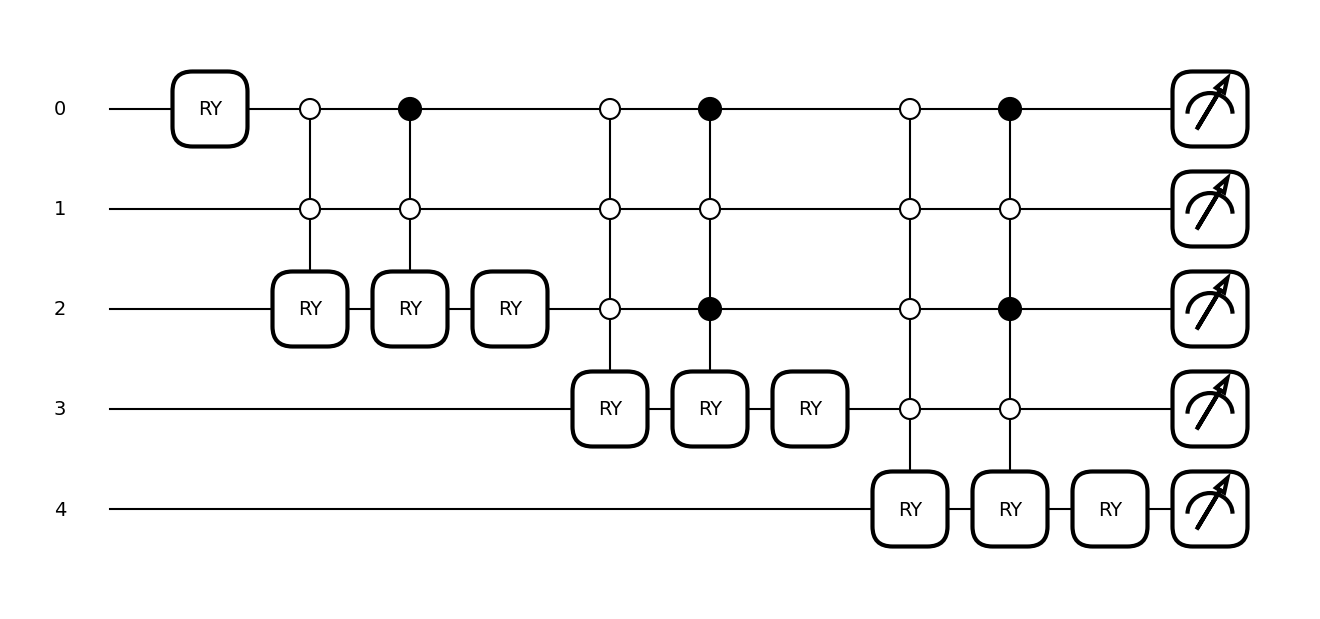

In [ ]:
ansatz.print_ansatz(init_method='GR',evaluation=False)

In [ ]:
ansatz.print_ansatz(init_method='GR',evaluation=True)

[2.334618494043994, 0.7555359420644393, 2.398849916898671, 2.410797543695789, 2.413919573557612, 0.7247407584430088]
6 [2.334618494043994, 0.7555359420644393, 2.398849916898671, 2.410797543695789, 2.413919573557612, 0.7247407584430088]


NotImplementedError: Applying a broadcasted unitary to an already broadcasted state via _apply_unitary is not supported. Broadcasting sizes are (2, 2).

In [ ]:
theta = np.array([2.334618494043994, 0.7555359420644393, 2.398849916898671, 2.410797543695789, 2.413919573557612, 0.7247407584430088])


class lol:
    def __init__(self):
        return    
    
    def build(self,theta):
        qml.RY(1.6,0)
        qml.ctrl(qml.RY,[0,1],[0,0])(theta[0],2)
        qml.ctrl(qml.RY,[0,1],[1,0])(theta[1],2)
        qml.RY(1.6,2)

        qml.ctrl(qml.RY,[0,1,2],[0,0,0])(theta[2],3)
        qml.ctrl(qml.RY,[0,1,2],[1,0,1])(theta[3],3)
        qml.RY(1.6,3)

        qml.ctrl(qml.RY,[0,1,2,3],[0,0,0,0])(theta[4],4)
        qml.ctrl(qml.RY,[0,1,2,3],[1,0,1,0])(theta[5],4)
        qml.RY(1.6,4)

    def evaluate(self,theta):
        @qml.qnode(dev)
        def circuit():
            self.build(theta)
            return np.real(qml.state())
        
        return circuit()
    
instance = lol()
print(instance.evaluate(theta))

    #@qml.qnode(dev)
    #def circuitlolol(theta):
    #    ansatz.GR_Mottonen_part()
    #    #ansatz.variational_subcircuit(theta)
    #    return np.real(qml.state())

#    print(circuitlol(theta))
#print("\nlol\n")
#print(qml.draw_mpl(circuitlolol)(theta))

[2023-09-21 12:32:37,408][DEBUG][<PID 6374:MainProcess>] - pennylane.qnode.__init__()::"Creating QNode(func=<function lol.evaluate.<locals>.circuit at 0x297025800>, device=<DefaultQubit device (wires=5, shots=None) at 0x2960efe90>, interface=auto, diff_method=best, expansion_strategy=gradient, max_expansion=10, grad_on_execution=best, mode=None, cache=True, cachesize=10000, max_diff=1, gradient_kwargs={}"
[2023-09-21 12:32:37,424][DEBUG][<PID 6374:MainProcess>] - pennylane.interfaces.execution.execute()::"Entry with args=(tapes=(<QuantumScript: wires=[0, 1, 2, 3, 4], params=6>,), device=<DefaultQubitAutograd device (wires=5, shots=None) at 0x294784f90>, gradient_fn=backprop, interface=autograd, grad_on_execution=best, gradient_kwargs={}, cache=True, cachesize=10000, max_diff=1, override_shots=False, expand_fn=device, max_expansion=10, device_batch_transform=True) called by=/Users/Brian/workspace/Research/Hamiltonian_simulation_BlackScholes/.conda/lib/python3.11/site-packages/pennylane/

In [ ]:
print(circuitlolol(theta))

[2023-09-21 12:17:49,666][DEBUG][<PID 6374:MainProcess>] - pennylane.interfaces.execution.execute()::"Entry with args=(tapes=(<QuantumScript: wires=[], params=0>,), device=<DefaultQubitAutograd device (wires=5, shots=None) at 0x296c03fd0>, gradient_fn=backprop, interface=autograd, grad_on_execution=best, gradient_kwargs={}, cache=True, cachesize=10000, max_diff=1, override_shots=False, expand_fn=device, max_expansion=10, device_batch_transform=True) called by=/Users/Brian/workspace/Research/Hamiltonian_simulation_BlackScholes/.conda/lib/python3.11/site-packages/pennylane/qnode.py::L989"


[2023-09-21 12:17:49,679][DEBUG][<PID 6374:MainProcess>] - pennylane.interfaces.execution.cache_execute()::"Entry with args=(fn=<function QubitDevice.batch_execute at 0x295542f20>, cache=LRUCache({}, maxsize=10000, currsize=0), pass_kwargs=False, return_tuple=False, expand_fn=None) called by=/Users/Brian/workspace/Research/Hamiltonian_simulation_BlackScholes/.conda/lib/python3.11/site-packages/pennylane/interfaces/execution.py::L238"
[2023-09-21 12:17:49,689][DEBUG][<PID 6374:MainProcess>] - pennylane._qubit_device.batch_execute()::"Entry with args=(circuits=(<QuantumScript: wires=[], params=0>,)) called by=/Users/Brian/workspace/Research/Hamiltonian_simulation_BlackScholes/.conda/lib/python3.11/contextlib.py::L81"
[2023-09-21 12:17:49,701][DEBUG][<PID 6374:MainProcess>] - pennylane._qubit_device.execute()::"Entry with args=(circuit=<QuantumScript: wires=[], params=0>, kwargs={}) called by=/Users/Brian/workspace/Research/Hamiltonian_simulation_BlackScholes/.conda/lib/python3.11/site-pa

In [ ]:
ansatz.GD_optimisation(1.5,1000,init_method='GR')

[2023-09-21 12:17:49,706][DEBUG][<PID 6374:MainProcess>] - pennylane.qnode.__init__()::"Creating QNode(func=<function Ansatz.evaluate_ansatz.<locals>.circuit at 0x2961ac5e0>, device=<DefaultQubit device (wires=5, shots=None) at 0x2960efe90>, interface=auto, diff_method=best, expansion_strategy=gradient, max_expansion=10, grad_on_execution=best, mode=None, cache=True, cachesize=10000, max_diff=1, gradient_kwargs={}"
[2023-09-21 12:17:49,729][DEBUG][<PID 6374:MainProcess>] - pennylane.interfaces.execution.execute()::"Entry with args=(tapes=(<QuantumScript: wires=[1, 2, 3, 4], params=0>,), device=<DefaultQubitAutograd device (wires=5, shots=None) at 0x296440510>, gradient_fn=backprop, interface=autograd, grad_on_execution=best, gradient_kwargs={}, cache=True, cachesize=10000, max_diff=1, override_shots=False, expand_fn=device, max_expansion=10, device_batch_transform=True) called by=/Users/Brian/workspace/Research/Hamiltonian_simulation_BlackScholes/.conda/lib/python3.11/site-packages/pen

KeyboardInterrupt: 

/Users/Brian/workspace/Research/Hamiltonian_simulation_BlackScholes/.conda/lib/python3.11/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


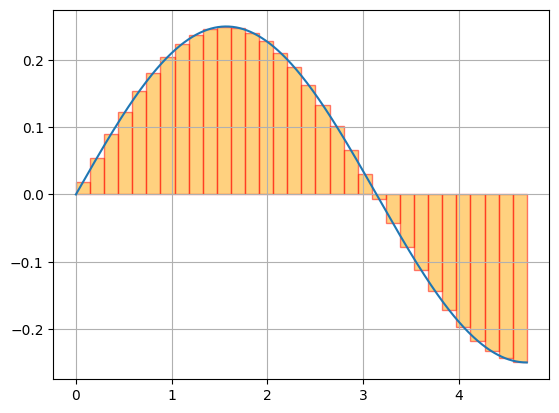

In [ ]:
x = np.linspace(x_min,x_max,1000)

fig, ax = plt.subplots()
ax.plot(x,[myfunction(e) for e in x])
ylim = ax.get_ylim()
ax.bar(normaliser,AmplitudeEmbedding(),color='orange',edgecolor='red',alpha=0.5,width = (x_max-x_min)/(2**n_qubits))
ax.set_ylim(ylim)
plt.grid()